## Import library

In [56]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

## Read dataset

In [57]:
dataset = pd.read_csv("./Ransomware_headers.csv")
display(dataset)

,ID,filename,GR,family,0,1,2,3,4,5,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,10000,2XClient_12.0_build_2193.paf.exe,0,0,77,90,144,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,7-ZipPortable_21.07.paf.exe,0,0,77,90,144,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2,10002,ARP.EXE,0,0,77,90,144,0,3,0,...,0,0,0,0,0,0,0,0,0,0
3,10003,AccountsControlHost.exe,0,0,77,90,144,0,3,0,...,0,0,0,0,0,0,0,0,0,0
4,10004,ActionUriServer.exe,0,0,77,90,144,0,3,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2152,21018,ece7ddff2ff9fdb8e7f55b674baa9c975ce86ff79e02db...,1,25,77,90,144,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2153,21019,f247ae6db52989c9a598c3c7fbc1ae2db54f5c65be8628...,1,25,77,90,80,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2154,21020,f38c40c74a0a9953697c63fbd375c064cb2d59ce478435...,1,25,77,90,144,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2155,21021,fa789f56ef3f5075fc02c53cd937fe1580ae46217cf0a8...,1,25,77,90,144,0,3,0,...,0,0,0,0,0,0,0,0,0,0


## Filter dataset and assign to rans_df and benign_df in a single statement

In [121]:
rans_df, benign_df = (dataset[dataset["GR"] > 0], dataset[dataset["GR"] == 0])

# Display to verify results
rans_df.shape, benign_df.shape

((1023, 1028), (1134, 1028))

## Convert columns 0 to 1024 as a features

In [59]:
rans_features = rans_df.iloc[:, 4:]
benign_features = benign_df.iloc[:, 4:]

rans_features.head(), benign_features.head()

(       0   1    2  3  4  5  6  7  8  9  ...  1014  1015  1016  1017  1018  \
 1134  77  90  144  0  3  0  0  0  4  0  ...     0     0     0     0     0   
 1135  77  90  144  0  3  0  0  0  4  0  ...     0     0     0     0     0   
 1136  77  90  144  0  3  0  0  0  4  0  ...     0     0     0     0     0   
 1137  77  90  144  0  3  0  0  0  4  0  ...     0     0     0     0     0   
 1138  77  90  144  0  3  0  0  0  4  0  ...     0     0     0     0     0   
 
       1019  1020  1021  1022  1023  
 1134     0     0     0     0     0  
 1135     0     0     0     0     0  
 1136     0     0     0     0     0  
 1137     0     0     0     0     0  
 1138     0     0     0     0     0  
 
 [5 rows x 1024 columns],
     0   1    2  3  4  5  6  7  8  9  ...  1014  1015  1016  1017  1018  1019  \
 0  77  90  144  0  3  0  0  0  4  0  ...     0     0     0     0     0     0   
 1  77  90  144  0  3  0  0  0  4  0  ...     0     0     0     0     0     0   
 2  77  90  144  0  3  0  0  0 

## Normalize features to the range [0, 1]

In [60]:
scaler = MinMaxScaler(feature_range=(0,1))

rans_normalized = scaler.fit_transform(rans_features)
benign_normalized = scaler.fit_transform(benign_features)

rans_features_normalized = pd.DataFrame(rans_normalized, columns=rans_features.columns)
benign_features_normalized = pd.DataFrame(benign_normalized, columns=benign_features.columns)

print(rans_features_normalized, benign_features_normalized)

        0    1         2    3         4    5    6    7         8    9  ...  \
0     0.0  0.0  0.554974  0.0  0.008658  0.0  0.0  0.0  0.021164  0.0  ...   
1     0.0  0.0  0.554974  0.0  0.008658  0.0  0.0  0.0  0.021164  0.0  ...   
2     0.0  0.0  0.554974  0.0  0.008658  0.0  0.0  0.0  0.021164  0.0  ...   
3     0.0  0.0  0.554974  0.0  0.008658  0.0  0.0  0.0  0.021164  0.0  ...   
4     0.0  0.0  0.554974  0.0  0.008658  0.0  0.0  0.0  0.021164  0.0  ...   
...   ...  ...       ...  ...       ...  ...  ...  ...       ...  ...  ...   
1018  0.0  0.0  0.554974  0.0  0.008658  0.0  0.0  0.0  0.021164  0.0  ...   
1019  0.0  0.0  0.219895  0.0  0.004329  0.0  0.0  0.0  0.021164  0.0  ...   
1020  0.0  0.0  0.554974  0.0  0.008658  0.0  0.0  0.0  0.021164  0.0  ...   
1021  0.0  0.0  0.554974  0.0  0.008658  0.0  0.0  0.0  0.021164  0.0  ...   
1022  0.0  0.0  0.554974  0.0  0.008658  0.0  0.0  0.0  0.021164  0.0  ...   

      1014  1015  1016  1017  1018  1019  1020  1021  1022  102

## Convert each row into a 2D array of 32x32

In [61]:
rans_feature_2d = rans_features.apply(lambda x: x.values.reshape(32, 32), axis=1)
benign_feature_2d = benign_features.apply(lambda x: x.values.reshape(32, 32), axis=1)

rans_feature_normalized_2d = rans_features_normalized.apply(lambda x: x.values.reshape(32, 32), axis=1)
benign_feature_normalized_2d = benign_features_normalized.apply(lambda x: x.values.reshape(32, 32), axis=1)

rans_feature_2d.head(), benign_feature_2d.head(), rans_feature_normalized_2d.head(), benign_feature_normalized_2d.head()

(1134    [[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255,...
 1135    [[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255,...
 1136    [[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255,...
 1137    [[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255,...
 1138    [[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255,...
 dtype: object,
 0    [[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255,...
 1    [[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255,...
 2    [[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255,...
 3    [[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255,...
 4    [[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255,...
 dtype: object,
 0    [[0.0, 0.0, 0.5549738219895288, 0.0, 0.0086580...
 1    [[0.0, 0.0, 0.5549738219895288, 0.0, 0.0086580...
 2    [[0.0, 0.0, 0.5549738219895288, 0.0, 0.0086580...
 3    [[0.0, 0.0, 0.5549738219895288, 0.0, 0.0086580...
 4    [[0.0, 0.0, 0.5549738219895288, 0.0, 0.0086580...
 dtype: object,
 0    [[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...
 1    [[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0

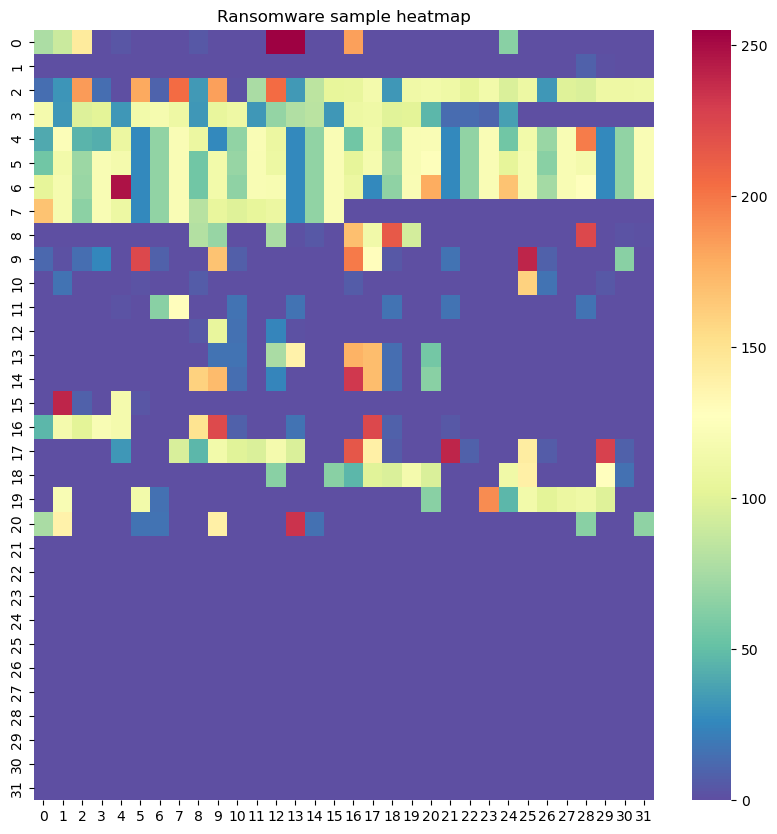

In [84]:
def plot_heatmap(feature_2d, title):
    plt.figure(figsize=(8, 8))
    sns.heatmap(feature_2d, cmap="Spectral_r", vmin=0, vmax=255, cbar=True)
    plt.title(title)
    plt.show()
    
plot_heatmap(rans_feature_2d.iloc[0], title="Ransomware sample heatmap")

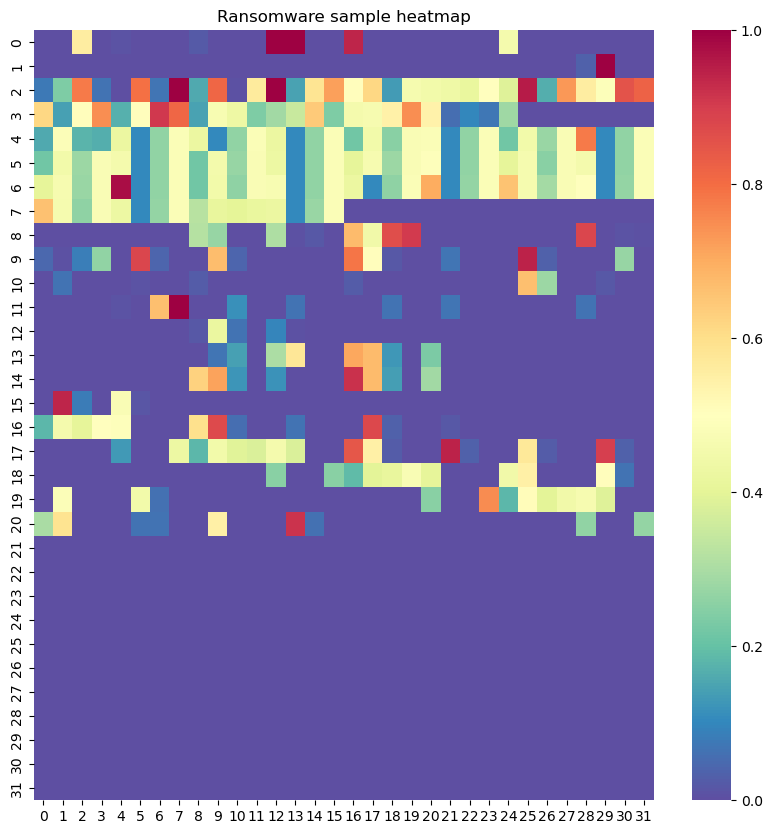

In [85]:
def plot_heatmap(feature_2d, title):
    plt.figure(figsize=(8, 8))
    sns.heatmap(feature_2d, cmap="Spectral_r", vmin=0, vmax=1, cbar=True)
    plt.title(title)
    plt.show()
    
plot_heatmap(rans_feature_normalized_2d.iloc[0], title="Ransomware sample heatmap")

# Function to plot and save a heatmap for a single 2D vector

In [118]:
def plot_and_save_heatmap(feature_2d, filename, save_dir, img_size=(333, 333)):
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Set the desired figure size based on img_size and dpi
    dpi = 100  # Set dpi for high-quality image
    figsize = (img_size[0] / dpi, img_size[1] / dpi)  # Calculate figsize in inches

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(feature_2d, cmap="Spectral_r", vmin=0, vmax=1, cbar=False, square=True, xticklabels=False, yticklabels=False)

    # Save the figure to the specified directory with the given filename
    filepath = os.path.join(save_dir, f"{filename}.png")
    plt.savefig(filepath, dpi=100, bbox_inches='tight', pad_inches=0)  # Save with specified dpi
    plt.close()  # Close the plot to free memory

    print(f"Saved heatmap as {filepath}")
    
# plot_and_save_heatmap(rans_feature_normalized_2d.iloc[0], filename=rans_df.iloc[0]["filename"], save_dir="ransomware_images")

for i in range(0, rans_feature_normalized_2d.size):
    plot_and_save_heatmap(rans_feature_normalized_2d.iloc[i], filename=rans_df.iloc[i]["filename"], save_dir="ransomware_images")
    
for i in range(0, benign_feature_normalized_2d.size):
    plot_and_save_heatmap(benign_feature_normalized_2d.iloc[i], filename=benign_df.iloc[i]["filename"], save_dir="benign_images")

Saved heatmap as ransomware_images\05af0cf40590aef24b28fa04c6b4998b7ab3b7f26e60c507adb84f3d837778f2.png
Saved heatmap as ransomware_images\09f01f2256663969229c2c954f7b29751b41a0c2b36cdb9b67c9491b76c04898.png
Saved heatmap as ransomware_images\0ff4058f709d278ed662719b9627618c48e7a656c59f6bfecda9081c7cbd742b.png
Saved heatmap as ransomware_images\1228d0f04f0ba82569fc1c0609f9fd6c377a91b9ea44c1e7f9f84b2b90552da2.png
Saved heatmap as ransomware_images\146712f0832c4e2fbe24245d18f2913746436e38d5438f5eca15dfd0fb50ec24.png
Saved heatmap as ransomware_images\17e68e1fb7737ec554eab4b7aea90ebb2fb23c953d920b8d8f1ab4825c3faede.png
Saved heatmap as ransomware_images\17efb277d1893fe4255b9178e9bf6ce55d8a514f9805fd2ab8f7065498c53d97.png
Saved heatmap as ransomware_images\1c53a211e69cb490911485d71573fd1a4210d7167094a6d7b28926157acd31f0.png
Saved heatmap as ransomware_images\1d5f21f26caefe394d6b217a654f0effb6a6a986257229daf447e8b8966f693e.png
Saved heatmap as ransomware_images\1e8df42c2e51f919886eaf955c8fc